In [2]:
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_frame=pd.read_csv("./adult.csv")
data_frame.isna().sum()
data_frame.replace("?",np.nan,inplace=True)
data_frame=data_frame.astype({col:int for col in data_frame.columns if data_frame[col].dtype=="bool"})
data_frame.drop(columns=["workclass","occupation","native.country"],inplace=True)
data_frame



,age,fnlwgt,education,education.num,marital.status,relationship,race,sex,capital.gain,capital.loss,hours.per.week,income
0,90,77053,HS-grad,9,Widowed,Not-in-family,White,Female,0,4356,40,<=50K
1,82,132870,HS-grad,9,Widowed,Not-in-family,White,Female,0,4356,18,<=50K
2,66,186061,Some-college,10,Widowed,Unmarried,Black,Female,0,4356,40,<=50K
3,54,140359,7th-8th,4,Divorced,Unmarried,White,Female,0,3900,40,<=50K
4,41,264663,Some-college,10,Separated,Own-child,White,Female,0,3900,40,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,310152,Some-college,10,Never-married,Not-in-family,White,Male,0,0,40,<=50K
32557,27,257302,Assoc-acdm,12,Married-civ-spouse,Wife,White,Female,0,0,38,<=50K
32558,40,154374,HS-grad,9,Married-civ-spouse,Husband,White,Male,0,0,40,>50K
32559,58,151910,HS-grad,9,Widowed,Unmarried,White,Female,0,0,40,<=50K


In [4]:
from  sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
for col in ["education","marital.status","relationship"	,"race"	,"sex","income"]:
    data_frame[col]=encoder.fit_transform(data_frame[col])
data_frame
data_frame["income"].value_counts()

income
0    24720
1     7841
Name: count, dtype: int64

<Axes: >

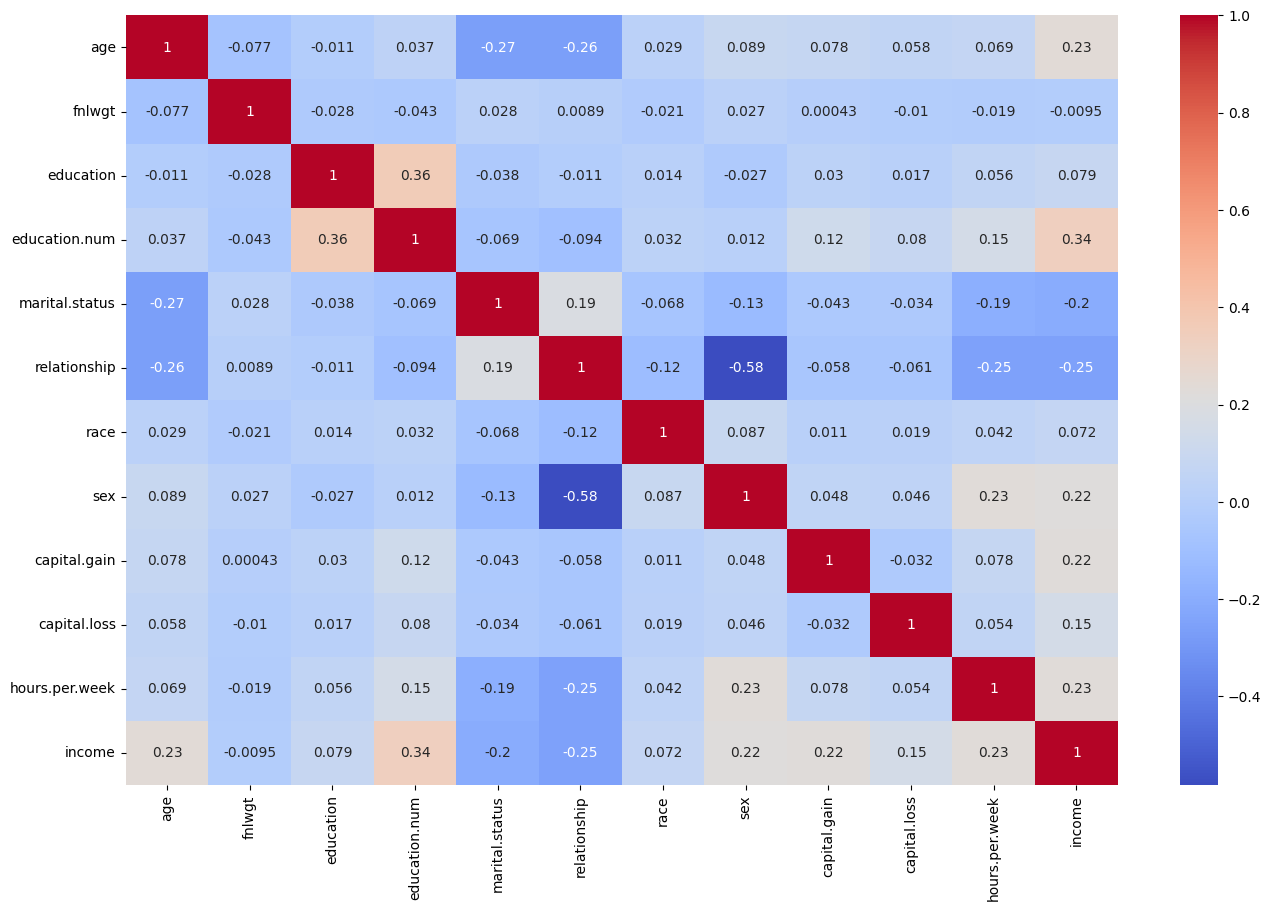

In [5]:
plt.figure(figsize=(16,10))
sns.heatmap(data_frame.corr(),annot=True,cmap="coolwarm")


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
y=data_frame["income"]
x=data_frame.drop(columns=["income",'fnlwgt'])
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.2)
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)
x_train=torch.tensor(x_train,dtype=torch.float32)
x_test=torch.tensor(x_test,dtype=torch.float32)
y_train=torch.tensor(y_train.to_numpy(),dtype=torch.float32).unsqueeze(1)
y_test=torch.tensor(y_test.to_numpy(),dtype=torch.float32).unsqueeze(1)
y_test.shape



torch.Size([6513, 1])

In [7]:
model=torch.nn.Sequential(
    torch.nn.Linear(x_train.shape[1],1028),
    torch.nn.BatchNorm1d(1028),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(1028,512),
    torch.nn.Linear(512,1)
)
loss_fn=torch.nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

val_losses=[]
train_losses=[]
train_accuracies=[]
test_accuracies=[]
epochs=50
for epoch in range(epochs):
    ypred=model.forward(x_train)
    print(ypred.shape)
    loss=loss_fn(ypred,y_train)
    train_losses.append(loss.item()*100)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_preds=(torch.sigmoid(ypred)>0.5).float()
    train_accuracy=(train_preds==y_train).float().mean()*100
    train_accuracies.append(train_accuracy)
    for name,param in model.named_parameters():
        print(f"{name} : {param.grad.mean()}")
    with torch.no_grad():
        val_pred=model.forward(x_test)
        val_loss=loss_fn(val_pred,y_test)
        val_losses.append(val_loss.item()*100)
        val_preds=(torch.sigmoid(val_pred)>0.5).float()
        test_accuracy=(val_preds==y_test).float().mean()*100
        test_accuracies.append(test_accuracy)
    print(f"epoch {epoch} : train  loss {loss*100} | val loss:{val_loss*100}")
    print(f"epoch {epoch} :  train accuracy {train_accuracy:.2f}% | val accuracy:{test_accuracy:.2f}%")


    


torch.Size([26048, 1])
0.weight : -7.118247140169842e-06
0.bias : -3.748541407833095e-12
1.weight : 1.7045920685632154e-05
1.bias : 5.165341462998185e-06
4.weight : -0.0001297754788538441
4.bias : -0.0003751009644474834
5.weight : -0.003276113886386156
5.bias : 0.24495965242385864
epoch 0 : train  loss 69.03156280517578 | val loss:98.49844360351562
epoch 0 :  train accuracy 52.51% | val accuracy:76.40%
torch.Size([26048, 1])
0.weight : 0.0003887399798259139
0.bias : -1.886361483682819e-10
1.weight : 0.0008464698330499232
1.bias : 0.0010469767730683088
4.weight : 0.0001318393915425986
4.bias : 0.00031349502387456596
5.weight : -0.0011420510709285736
5.bias : -0.2047278881072998
epoch 1 : train  loss 102.06285858154297 | val loss:74.18582916259766
epoch 1 :  train accuracy 75.80% | val accuracy:76.40%
torch.Size([26048, 1])
0.weight : 0.0003083803167100996
0.bias : -1.2997160292460563e-10
1.weight : 0.0005467364098876715
1.bias : 0.0007118412177078426
4.weight : 0.00011663093027891591
4.

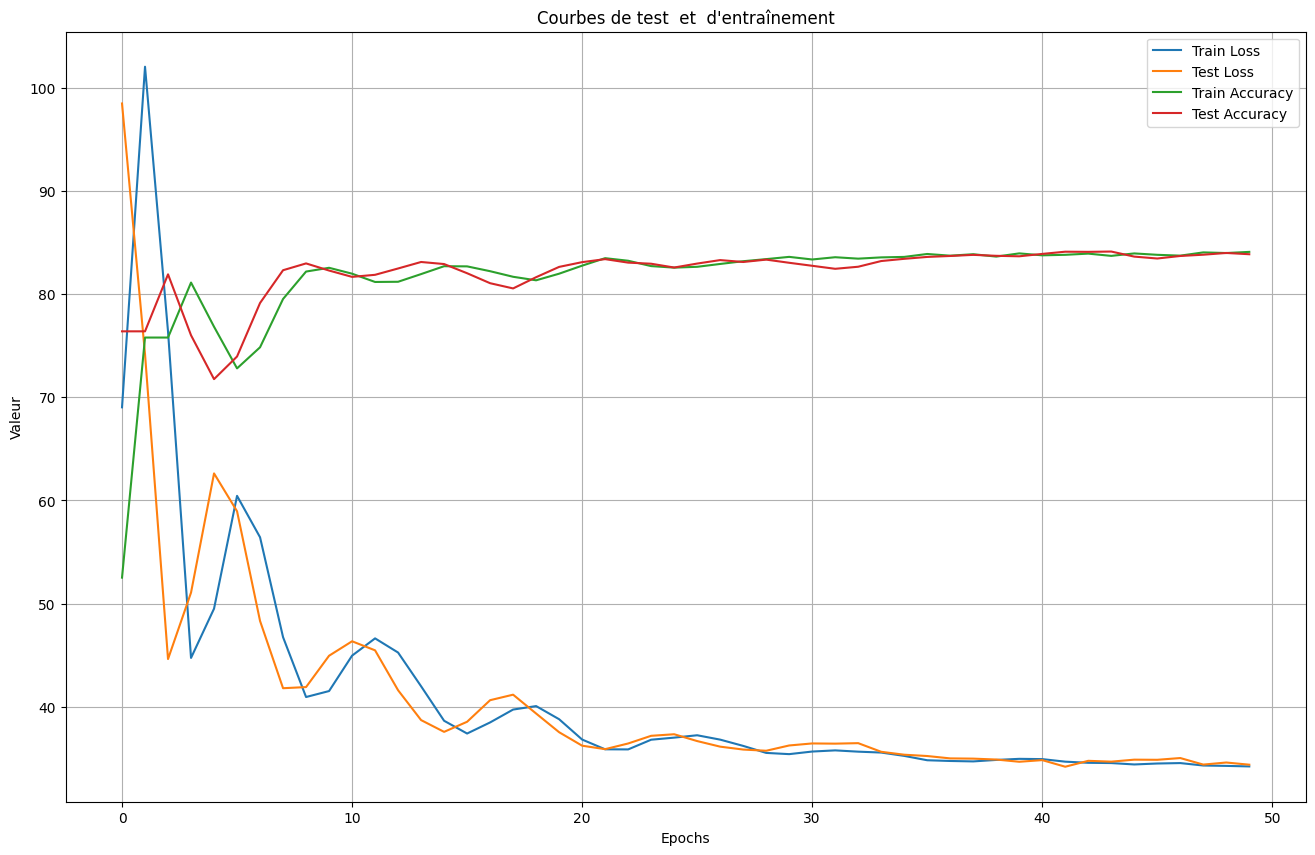

[tensor(76.4010), tensor(76.4010), tensor(81.9285), tensor(76.0172), tensor(71.7642), tensor(73.9598), tensor(79.1494), tensor(82.3277), tensor(82.9879), tensor(82.2969), tensor(81.6828), tensor(81.8824), tensor(82.4966), tensor(83.1261), tensor(82.9265), tensor(82.0359), tensor(81.0686), tensor(80.5620), tensor(81.6521), tensor(82.6501), tensor(83.1107), tensor(83.4024), tensor(83.0646), tensor(82.9572), tensor(82.5887), tensor(82.9725), tensor(83.3103), tensor(83.1261), tensor(83.3564), tensor(83.0493), tensor(82.7576), tensor(82.4658), tensor(82.6654), tensor(83.2182), tensor(83.4331), tensor(83.6174), tensor(83.7095), tensor(83.8170), tensor(83.7249), tensor(83.6788), tensor(83.9091), tensor(84.1241), tensor(84.1087), tensor(84.1394), tensor(83.6481), tensor(83.4638), tensor(83.7095), tensor(83.8323), tensor(84.0012), tensor(83.8784)]


In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
axe = plt.subplot(1, 1, 1)

axe.plot(range(epochs), train_losses, label="Train Loss")
axe.plot(range(epochs), val_losses, label="Test Loss")
axe.plot(range(epochs), train_accuracies, label="Train Accuracy")
axe.plot(range(epochs), test_accuracies, label="Test Accuracy")

axe.set_xlabel("Epochs")
axe.set_ylabel("Valeur")
axe.set_title("Courbes de test  et  d'entraînement")
axe.legend()
axe.grid(True)
plt.show()
print(test_accuracies)